![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Análise Exploratória com Inferência de Efeito Causal a partir de SRAGs

Neste *notebook* analisamos os dados reportados de casos de Síntrome Respiratória Aguda Grave (SRAG), sob a hipótese de que desse número se possa estimar uma boa aproximação do número real da incidência de COVID-19, já que supõe-se que a epidemia esteja subnotificada. A inferência de efeito causal é feita de modo rudimentar, empregando-se a versão Python da biblioteca [CausalImpact](https://github.com/dafiti/causalimpact).

Os dados analisados foram extraídos do sistema [Info Gripe da Fiocruz](http://info.gripe.fiocruz.br/) por um [*scrapper* não-oficial](https://github.com/belisards/srag_brasil/) (até o momento, não encontramos modo mais conveniente de acessar os dados originais diretamente).

**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
from causalimpact import CausalImpact
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/jinja2/utils.py:485: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/home/salem/anaconda3/lib/python3.7/site-packages/causalimpact/summary.py:32: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/salem/anaconda3/lib/python3.7/site-packages/causalimpact/templates/summary' mode='r' encoding='UTF-8'>
  SUMMARY_TMPL = Template(open(summary_tmpl_path).read())
/home/salem/anaconda3/lib/python3.7/site-packages/causalimpact/summary.py:33: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/salem/anaconda3/lib/python3.7/site-packages/causalimpact/templates/report' mode='r' encoding='UTF-8'>
  REPORT_TMPL = Template(open(report_tmpl_path).read())
/home/salem/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will b

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

Tomemos o cuidado de determinar o dia em que as semanas epidemiológicas terminam, que [parece ser aos sábados](https://portalsinan.saude.gov.br/calendario-epidemiologico).

In [4]:
week_offset = pd.offsets.Week(weekday=5)

## Leitura e Preparação



In [5]:
df_covid = pd.read_csv(f'../data/ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])

df_covid_target = df_covid[df_covid['location'] == 'Brazil'].set_index('date').resample(week_offset).sum()
df_covid_target.head(15)

,new_cases,new_deaths,total_cases,total_deaths
date,,,,
2020-01-04,0,0,0,0
2020-01-11,0,0,0,0
2020-01-18,0,0,0,0
2020-01-25,0,0,0,0
2020-02-01,0,0,0,0
2020-02-08,0,0,0,0
2020-02-15,0,0,0,0
2020-02-22,0,0,0,0
2020-02-29,1,0,4,0


In [6]:
# https://github.com/belisards/srag_brasil/
df_srag_raw = pd.read_csv(f'../data/srag_brasil/casos_br.csv')

df_srag_raw.head()

,ano,epiweek,casos,territory_name,situation_name,value
0,2009,1,0,Brasil,Dado estável. Sujeito a pequenas alterações.,0
1,2010,1,162,Brasil,Dado estável. Sujeito a pequenas alterações.,162 (100.0 % do país)
2,2011,1,30,Brasil,Dado estável. Sujeito a pequenas alterações.,30 (100.0 % do país)
3,2012,1,70,Brasil,Dado estável. Sujeito a pequenas alterações.,70 (100.0 % do país)
4,2013,1,74,Brasil,Dado estável. Sujeito a pequenas alterações.,74 (100.0 % do país)


## Comparação Das Semanas Epidemiológicas

Como foi a incidência de SRAG ao longo dos anos, quando comparamos as mesmas semanas?

In [7]:
cols = {}
timeline = []
years = df_srag_raw['ano'].unique()
for year in years:
    cols[year] = df_srag_raw[df_srag_raw['ano'] == year].sort_values('epiweek')['casos'].reset_index(drop=True)
    timeline = timeline + list(cols[year].values)

df_srag_timeline = pd.DataFrame(timeline) 
df_srag = pd.DataFrame(cols)
df_srag.head()

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,162,30,70,74,80,111,92,189,185,277,292.0
1,0,131,23,47,73,132,113,90,163,168,256,323.0
2,0,108,25,51,73,118,98,98,152,167,222,306.0
3,0,122,19,55,92,111,87,104,158,141,233,302.0
4,0,123,31,48,86,116,104,119,206,144,278,308.0


Text(0.5, 1.0, 'SRAG por semana epidemiológica por ano')

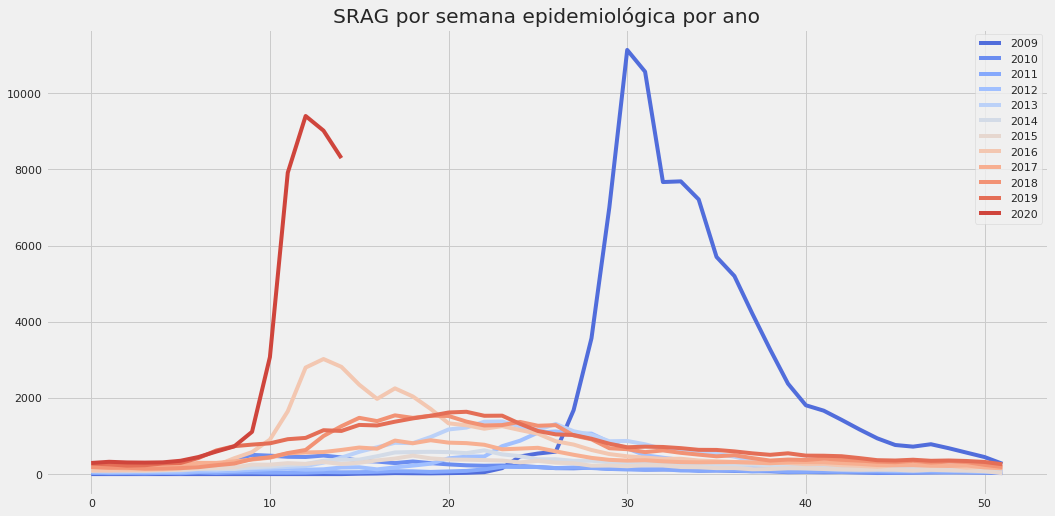

In [8]:
palette = sns.color_palette("coolwarm", len(df_srag.columns))
ax = sns.lineplot(data=df_srag, palette=palette, dashes=False)
ax.set_title('SRAG por semana epidemiológica por ano')

Uma visão alternativa para esses mesmos dados, que enfatiza a proporção em cada ano.

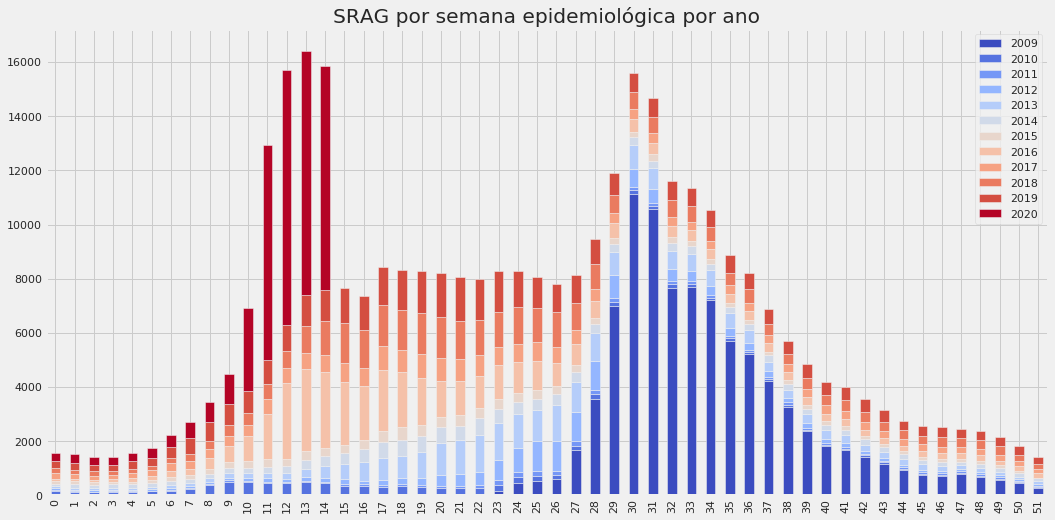

In [9]:
df_srag.plot(kind='bar', stacked=True, colormap='coolwarm', title='SRAG por semana epidemiológica por ano')

Vemos que em 2009 houve um pico bastante anormal, certamente por conta da epidemia de H1N1.

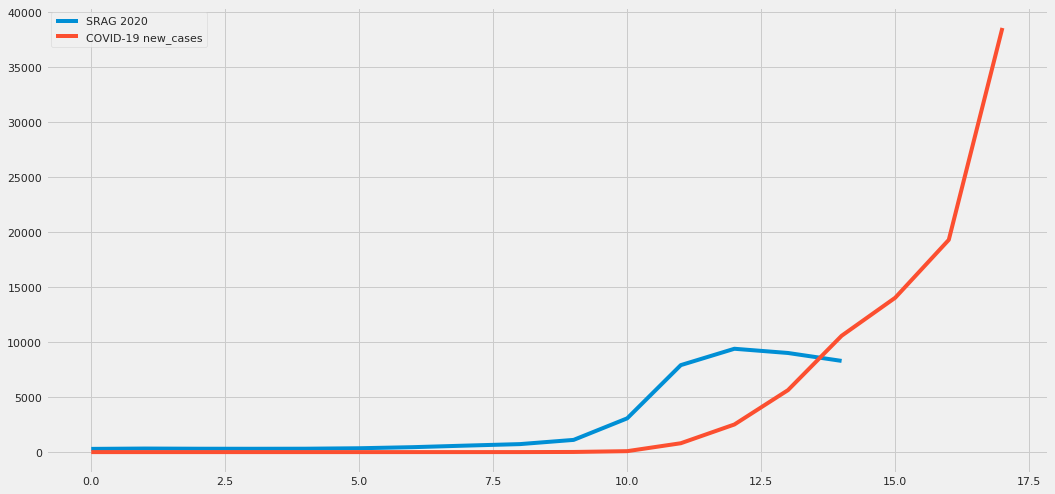

In [10]:
df_comparison =pd.concat([df_srag[2020].rename('SRAG 2020'), 
                          df_covid_target['new_cases'].rename('COVID-19 new_cases').reset_index(drop=True)], axis=1)

ax = sns.lineplot(data=df_comparison, dashes=False)

Qual a magnitude da diferença ao longo do tempo?

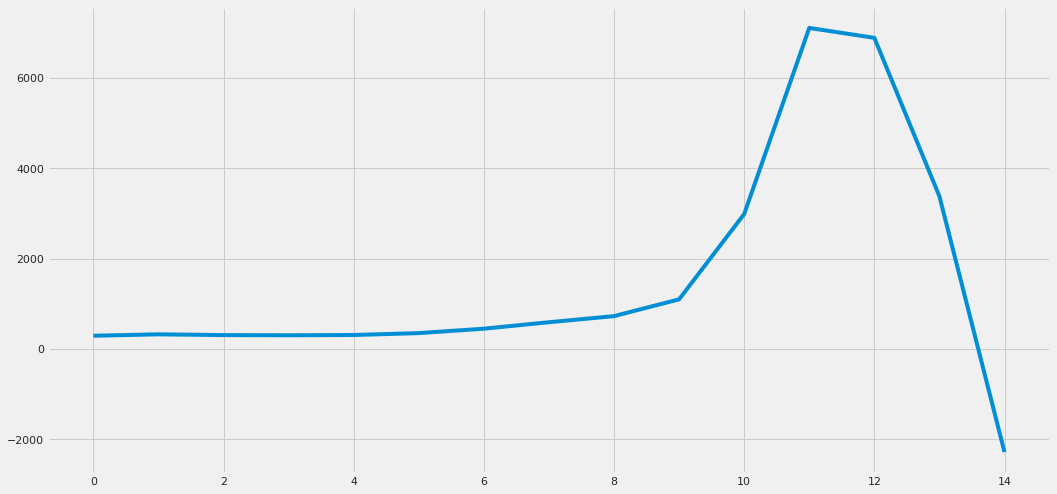

In [11]:
ax = sns.lineplot(data=(df_comparison.iloc[:, 0] - df_comparison.iloc[:, 1]), dashes=False)

## Estimativa de Efeito Causal: CausalImpact

Para estimar o efeito causal supostamente introduzido pela COVID-19, usaremos [a biblioteca CausalImpact](https://github.com/dafiti/causalimpact), a qual exige que os dados sejam dispostos de forma linear no tempo.

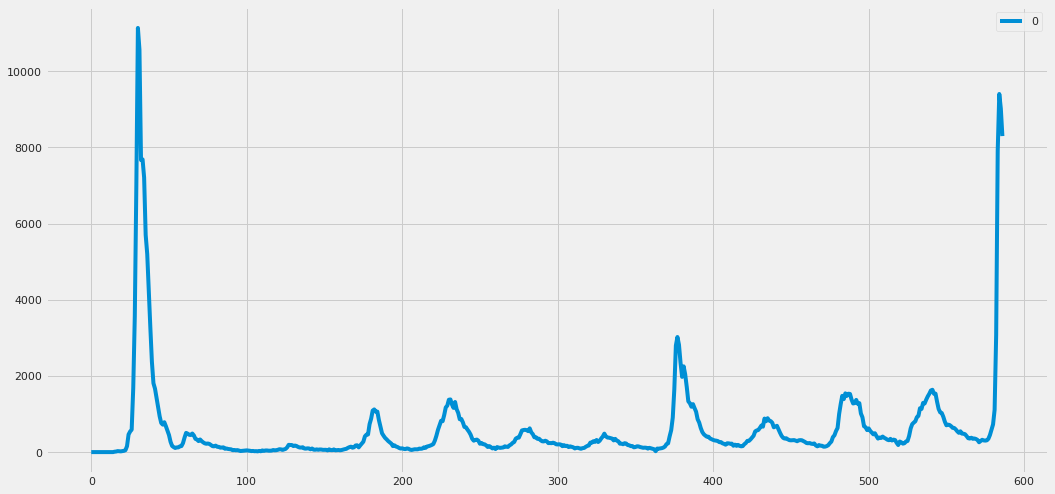

In [12]:
ax = sns.lineplot(data=df_srag_timeline, dashes=False)

Coloquemos a suposta intervenção causal na primeira semana de 2020.

In [13]:
years

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020])

Intervention week: 572
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2605.46            33871.0
Prediction (s.d.)         627.51 (296.61)    8157.63 (3855.91)
95% CI                    [18.35, 1181.04]   [238.57, 15353.47]

Absolute effect (s.d.)    1977.95 (296.61)   25713.37 (3855.91)
95% CI                    [1424.43, 2587.11] [18517.53, 33632.43]

Relative effect (s.d.)    315.21% (47.27%)   315.21% (47.27%)
95% CI                    [227.0%, 412.28%]  [227.0%, 412.28%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


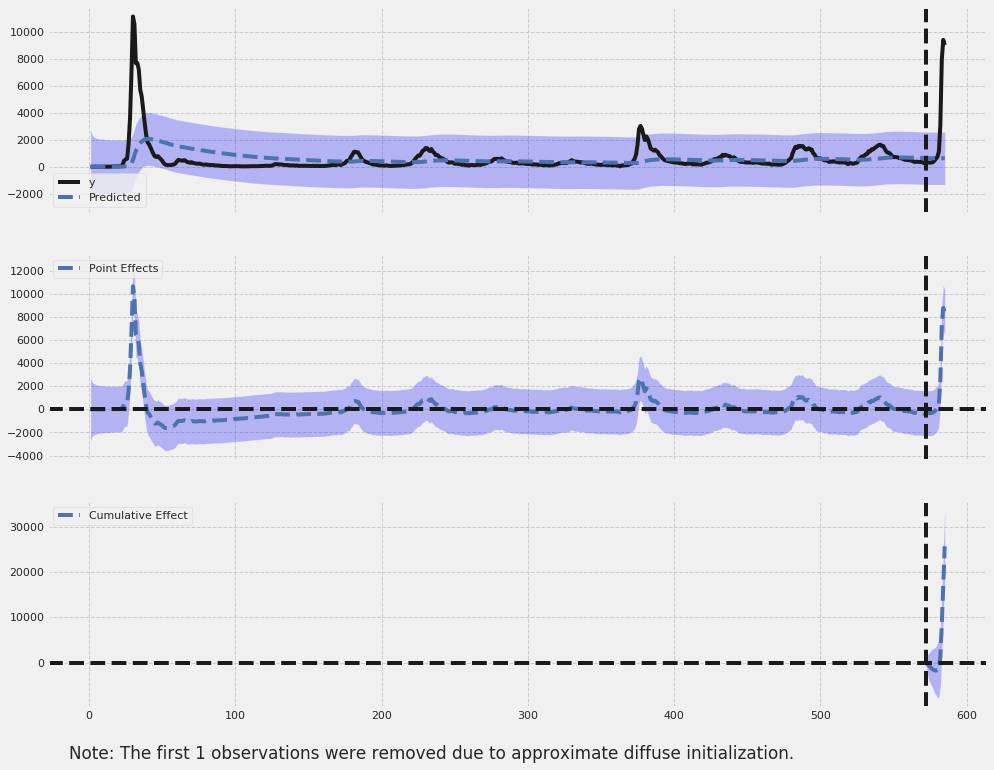

In [14]:
intervention_week = (len(years) - 1) * 52  # all years, except the last one
print("Intervention week:", intervention_week)
pre_period = [0, intervention_week]
post_period = [intervention_week+1, 585]

ci = CausalImpact(df_srag_timeline, pre_period, post_period)
print(ci.summary())
#print(ci.summary(output='report'))
ci.plot()

Podemos então isolar o efeito estimado.

In [15]:
df_causal_effect_1 = ci.inferences.dropna()[['point_effects', 'point_effects_lower', 'point_effects_upper']]
df_causal_effect_1#.head()

,point_effects,point_effects_lower,point_effects_upper
573,-304.510244,-2250.809110,1641.788621
574,-321.510244,-2267.959200,1624.938711
575,-325.510244,-2272.109279,1621.088790
576,-319.510244,-2266.259346,1627.238857
577,-277.510244,-2224.409401,1669.388912
578,-179.510244,-2126.559445,1767.538956
579,-36.510244,-1983.709477,1910.688988
580,99.489756,-1847.859498,2046.839009
581,482.489756,-1465.009507,2429.989018
582,2444.489756,496.840495,4392.139016


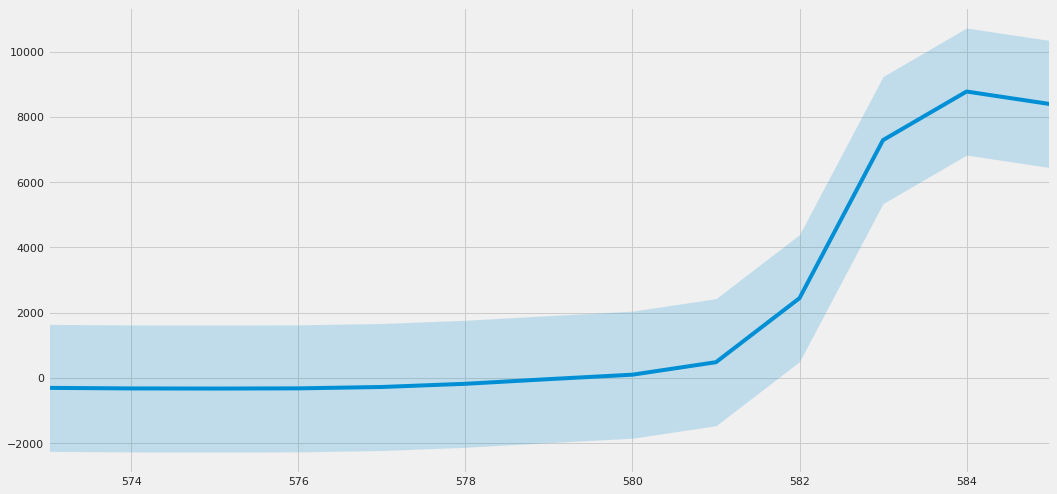

In [16]:
df_causal_effect_1['point_effects'].plot()
plt.fill_between(df_causal_effect_1.index, 
                 df_causal_effect_1[['point_effects_lower', 'point_effects_upper']].values[:, 0],
                df_causal_effect_1[['point_effects_lower', 'point_effects_upper']].values[:, 1],
                alpha=0.2)

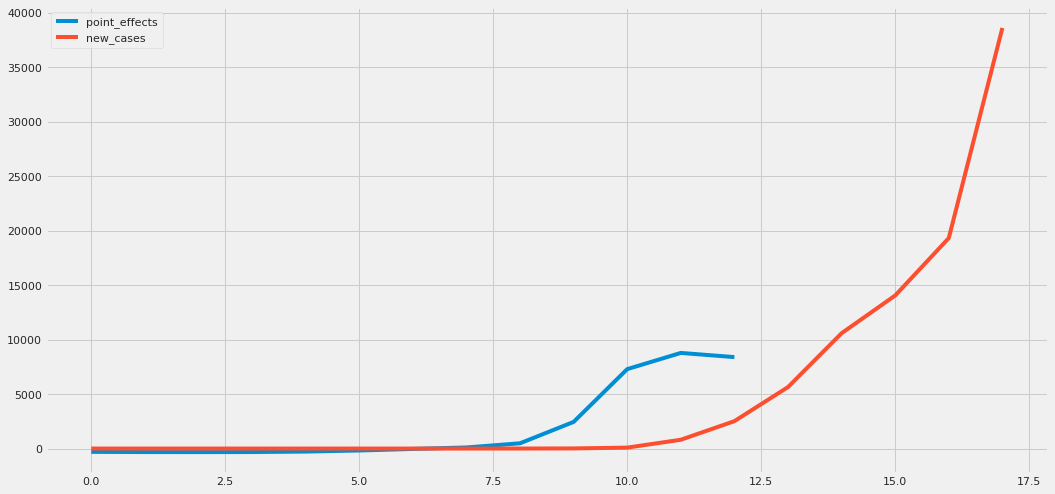

In [17]:
df_comparison_2 =pd.concat([df_causal_effect_1['point_effects'].reset_index(drop=True), 
                            df_covid_target['new_cases'].reset_index(drop=True)], axis=1)

ax = sns.lineplot(data=df_comparison_2, dashes=False)

E calcular a razão entre SRAGs e COVID-19 oficial.

8     482.489756
9     203.707480
10     85.723409
11     10.886464
12      3.338834
dtype: float64

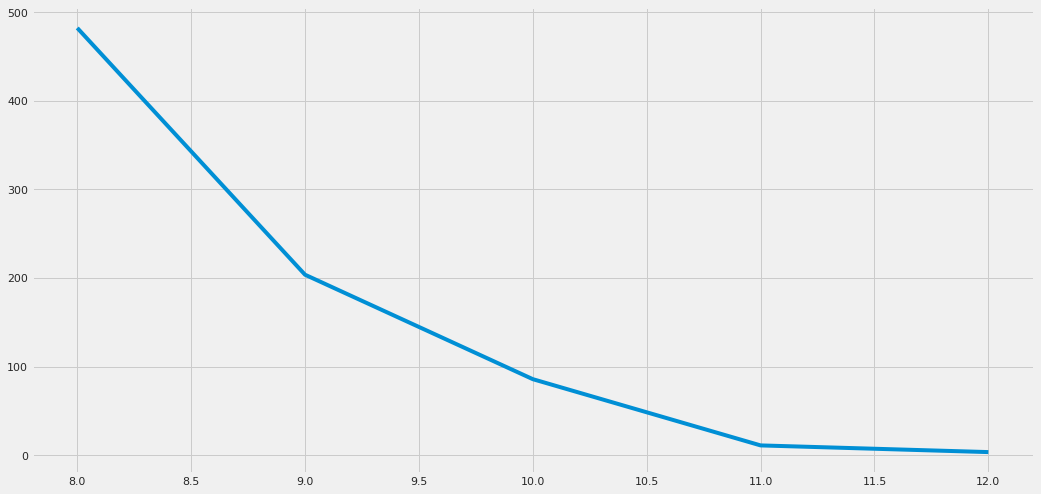

In [18]:
s_a = df_causal_effect_1['point_effects'].reset_index(drop=True)
s_b =  df_covid_target['new_cases'].reset_index(drop=True)
s_ratio_1 = (s_a/s_b)
s_ratio_1 = s_ratio_1[(s_ratio_1 != np.inf) & (s_ratio_1 != -np.inf)].dropna()
ax = sns.lineplot(data=s_ratio_1, 
                  dashes=False)
s_ratio_1

## Estimativa de Efeito Causal: Manual

Façamos agora uma análise manual, supondo-se que as mesmas semanas epidemiológicas em anos diferentes tendem a ter comportamentos semelhantes, salvo em casos excepcionais. Assim, iremos atribuir a diferença (média, mínima, máxima) observada nas semanas do ano corrente a algum fator novo, nomeadamente à COVID-19.

In [19]:
s_srag_cur = df_srag.iloc[:, -1]
df_srag_past = df_srag.iloc[:, :-1]

In [20]:
s_effect_lower = (s_srag_cur - df_srag_past.max(axis=1)).rename('causal_effect_lower')
s_effect_upper = (s_srag_cur - df_srag_past.min(axis=1)).rename('causal_effect_upper')
s_effect_mean = (s_srag_cur - df_srag_past.mean(axis=1)).rename('causal_effect_mean')


df_causal_effect_2 = pd.concat([s_effect_mean, s_effect_lower, s_effect_upper], axis=1) 
df_causal_effect_2.head(15)

,causal_effect_mean,causal_effect_lower,causal_effect_upper
0,176.545455,15.0,292.0
1,214.272727,67.0,323.0
2,204.909091,84.0,306.0
3,200.000000,69.0,302.0
4,193.909091,30.0,308.0
5,223.909091,58.0,350.0
6,285.090909,25.0,448.0
7,397.090909,-28.0,591.0
8,479.636364,-6.0,727.0
9,804.181818,336.0,1110.0


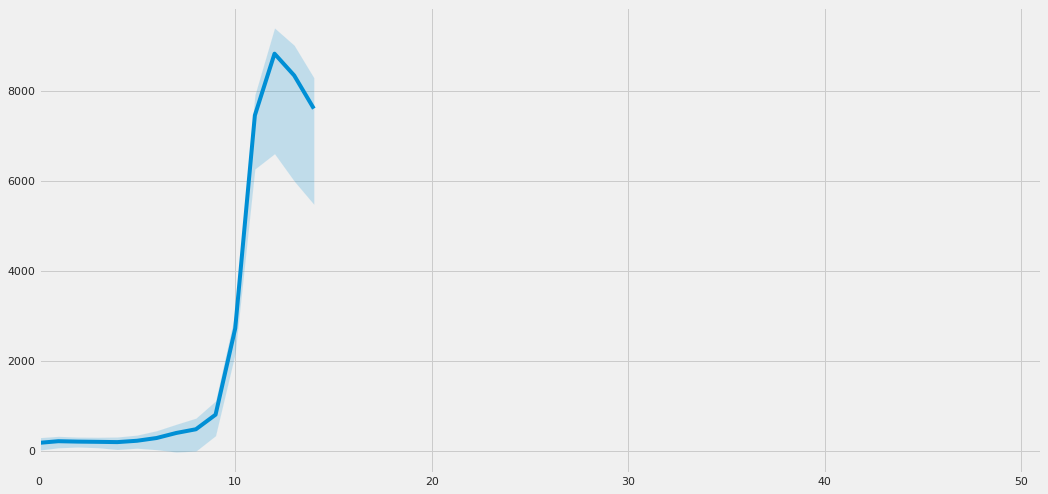

In [21]:
df_causal_effect_2['causal_effect_mean'].plot()
plt.fill_between(df_causal_effect_2.index, 
                 df_causal_effect_2[['causal_effect_lower', 'causal_effect_upper']].values[:, 0],
                 df_causal_effect_2[['causal_effect_lower', 'causal_effect_upper']].values[:, 1],
                 alpha=0.2)

8     479.636364
9      67.015152
10     32.020321
11      9.254004
12      3.513656
13      1.480066
14      0.719017
dtype: float64

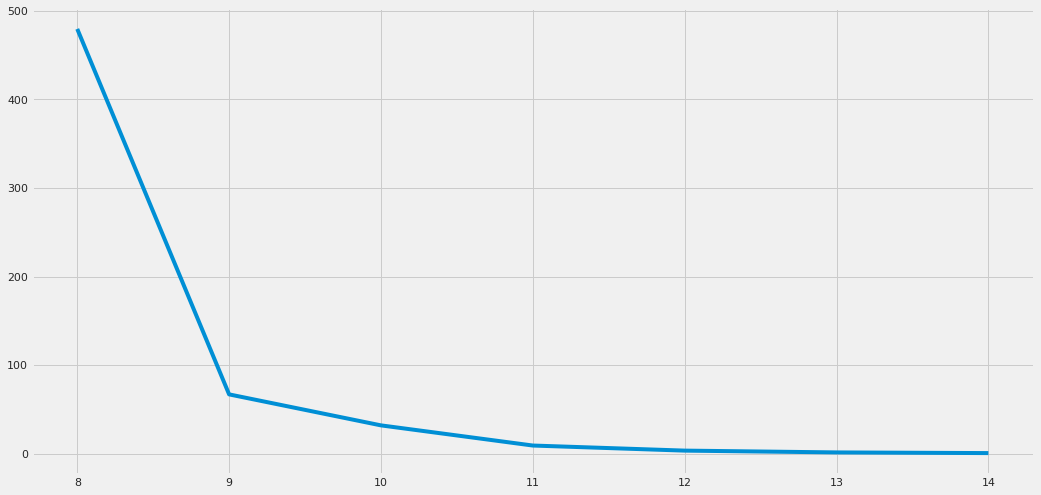

In [22]:
s_a = df_causal_effect_2['causal_effect_mean'].reset_index(drop=True)
s_b =  df_covid_target['new_cases'].reset_index(drop=True)

s_ratio_2 = (s_a/s_b)

s_ratio_2 = s_ratio_2[(s_ratio_2 != np.inf) & (s_ratio_2 != -np.inf)].dropna()
ax = sns.lineplot(data=s_ratio_2, 
                  dashes=False)
s_ratio_2

Os resultados dessa última estimativa de efeito causal parecem mais confiáveis, então a tomaremos como base para a conclusão deste estudo.

In [23]:
s_ratio = s_ratio_2

## Conclusão

Nota-se grande discrepância entre casos usuais de SRAG e casos reportados. Atribuimos assim os casos adicionais à COVID-19. Note-se ainda que os casos de SRAG reportados referem-se a hospitalizações, que são apenas uma parte dos casos totais esperados de COVID-19. Portanto, para se estimar os casos totais de COVID-19, devemos ainda ajustar a estimativa de hospitalizados de acordo com a probabilidade de ser hospitalizado dado que se tem COVID-19.

In [24]:
p_hospitalization = 0.2

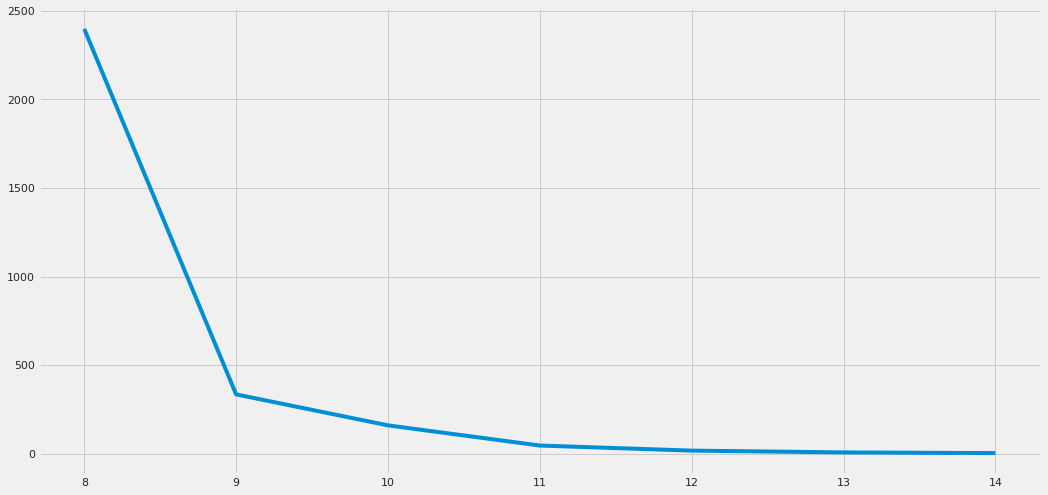

In [25]:
s_adjustment_multipler = s_ratio[s_ratio > 0] / p_hospitalization
s_adjustment_multipler = s_adjustment_multipler.rename('SRAG_adjustment_multiplier')
ax = sns.lineplot(data=s_adjustment_multipler, 
                  dashes=False)

Vemos assim que as diferenças estimadas são bastante expressivas, o que deve ter impacto na previsão da dinâmica epidemiológica.

Salvemos esses multiplicadores de ajuste para uso posterior. Por conveniência, vamos diarizar esses valores.

In [26]:
weeks = range(0, s_adjustment_multipler.index[-1])

In [27]:
df_daily_adjustment_multipler = \
    df_covid_target\
        .reset_index()\
        .merge(s_adjustment_multipler, left_index=True, right_index=True)\
        .set_index('date')\
        .resample('D')\
        .bfill()\
        [['SRAG_adjustment_multiplier']]

df_daily_adjustment_multipler

,SRAG_adjustment_multiplier
date,
2020-02-29,2398.181818
2020-03-01,335.075758
2020-03-02,335.075758
2020-03-03,335.075758
2020-03-04,335.075758
2020-03-05,335.075758
2020-03-06,335.075758
2020-03-07,335.075758
2020-03-08,160.101604


In [28]:
df_daily_adjustment_multipler.to_csv('../results/srag_adjustment_multipliers.brazil.csv')